PyTorch cGAN implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook assumes 03.library_usage.ipynb was run.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Quick hack to put us in the icenet-pipeline folder,
# assuming it was created as per 01.cli_demonstration.ipynb
import os
if os.path.exists("2_icenet2_forecast_gan.ipynb"):
    os.chdir("../../notebook-pipeline")
print("Running in {}".format(os.getcwd()))

%matplotlib inline

Running in /data/hpcdata/users/bryald/git/icenet/notebook-pipeline


In [4]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_data.json"
dataset_name = "pytorch_notebook"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_data.json


We generate a config only dataset, which will get saved in `dataset_config.pytorch_notebook.json`.

In [5]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.pytorch_notebook.json


We can now create the IceNetDataSet object:

In [6]:
dataset_config = "dataset_config.pytorch_notebook.json"

## Custom PyTorch Dataset

In [7]:
from icenet.data.dataset import IceNetDataSet
from torch.utils.data import Dataset, DataLoader

class IceNetDataSetPyTorch(Dataset):
    def __init__(self,
                 configuration_path: str,
                 mode: str,
                 batch_size: int = 1,
                 shuffling: bool = False,
                ):
        self._ds = IceNetDataSet(configuration_path=configuration_path,
                                 batch_size=batch_size,
                                 shuffling=shuffling)
        self._dl = self._ds.get_data_loader()

        # check mode option
        if mode not in ["train", "val", "test"]:
            raise ValueError("mode must be either 'train', 'val', 'test'")
        self._mode = mode

        self._dates = self._dl._config["sources"]["osisaf"]["dates"][self._mode]

    def __len__(self):
        return self._ds._counts[self._mode]
    
    def __getitem__(self, idx):
        x, y, sample_weights = self._dl.generate_sample(date=pd.Timestamp(self._dates[idx].replace('_', '-')),
                                        parallel=False,
                                        )
        return x, y, sample_weights

    def get_data_loader(self):
        return self._ds.get_data_loader()
    
    @property
    def dates(self):
        return self._dates

In [8]:
batch_size = 4
shuffle = False
persistent_workers=True
num_workers = 4

## IceNet2 UNet model

PyTorch UNet implementation based on current state of IceNet2, and Andrew's work from https://github.com/ampersandmcd/icenet-gan/.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

class UNet(nn.Module):
    def __init__(self,
                 input_channels,
                 filter_size=3,
                 n_filters_factor=1,
                 n_forecast_days=7,
                 n_output_classes=1,
                 **kwargs
                 ):
        super(UNet, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes

        start_out_channels = 64
        reduced_channels = int(start_out_channels * n_filters_factor)
        channels = {
            start_out_channels * 2**pow: reduced_channels * 2**pow
            for pow in range(4)
        }

        # Encoder
        self.conv1 = self.conv_block(input_channels, channels[64])
        self.conv2 = self.conv_block(channels[64], channels[128])
        self.conv3 = self.conv_block(channels[128], channels[256])
        self.conv4 = self.conv_block(channels[256], channels[256])

        # Bottleneck
        self.conv5 = self.bottleneck_block(channels[256], channels[512])

        # Decoder
        self.up6 = self.upconv_block(channels[512], channels[256])
        self.up7 = self.upconv_block(channels[256], channels[256])
        self.up8 = self.upconv_block(channels[256], channels[128])
        self.up9 = self.upconv_block(channels[128], channels[64])

        self.up6b = self.conv_block(channels[512], channels[256])
        self.up7b = self.conv_block(channels[512], channels[256])
        self.up8b = self.conv_block(channels[256], channels[128])
        self.up9b = self.conv_block(channels[128], channels[64], final=True)

        # Final layer
        self.final_layer = nn.Conv2d(channels[64], n_forecast_days, kernel_size=1, padding="same")

    def forward(self, x):
        # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # Encoder
        bn1 = self.conv1(x)
        conv1 = F.max_pool2d(bn1, kernel_size=2)
        bn2 = self.conv2(conv1)
        conv2 = F.max_pool2d(bn2, kernel_size=2)
        bn3 = self.conv3(conv2)
        conv3 = F.max_pool2d(bn3, kernel_size=2)
        bn4 = self.conv4(conv3)
        conv4 = F.max_pool2d(bn4, kernel_size=2)

        # Bottleneck
        bn5 = self.conv5(conv4)

        # Decoder
        up6 = self.up6b(torch.cat([bn4, self.up6(bn5)], dim=1))
        up7 = self.up7b(torch.cat([bn3, self.up7(up6)], dim=1))
        up8 = self.up8b(torch.cat([bn2, self.up8(up7)], dim=1))
        up9 = self.up9b(torch.cat([bn1, self.up9(up8)], dim=1))

        # Final layer
        output = self.final_layer(up9)

        # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
        output = torch.movedim(output, 1, -1)  # move c from second to final dim

        b, h, w, c = output.shape

        # unpack c=classes*months dimension into classes, months as separate dimensions
        output = output.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

        # print("n_forecast_days in UNet:", self.n_forecast_days)

        return output

    def conv_block(self, in_channels, out_channels, final=False):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
        )
        if not final:
            batch_norm = nn.Sequential(
                nn.BatchNorm2d(num_features=out_channels),
            )
            return nn.Sequential().extend(block).extend(batch_norm)
        else:
            final_block = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
                nn.ReLU(inplace=True),
            )
            return nn.Sequential().extend(block).extend(final_block)


    def bottleneck_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=out_channels),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            Interpolate(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same"),
            nn.ReLU(inplace=True)
        )

Generator and Discriminator classes for GAN, from Andrew's Masters work:

https://github.com/ampersandmcd/icenet-gan/blob/4ad72b61178a79c8d08ed75c5649207d6e37ebda/src/models.py#L277

In [10]:
class Generator(UNet):
    """
    An implementation of a conditional GAN which combines predictors and noise in a UNet.
    """
    
    def __init__(self,
                 input_channels,
                 filter_size=3,
                 n_filters_factor=1,
                 n_forecast_days=7,
                 n_output_classes=1,
                 sigma=1,
                 **kwargs):
        """
        Constructs underlying UNet and adds some additional GAN-specific logic.
        :param seed: Seed for the generator's underlying random noise generator
        :param sigma: Standard deviation parameter for underlying random noise generator.
            In theory, higher values will lead to higher-temperature samples, with a more
            noticeable impact on the resulting generated image.
        """
        
        # construct UNet
        super(Generator, self).__init__(
            input_channels + 1,
            filter_size,
            n_filters_factor,
            n_forecast_days,
            n_output_classes,
            **kwargs
        )

        # set sigma
        self.sigma = sigma
        
    def forward(self, x, noise=None):

        # sample noise in the shape of the image
        # seed self.generator before this step if you want determinism
        b, h, w, c = x.shape
        if noise is None:
            noise = torch.randn(b, h, w, 1, device=x.device) * self.sigma

        # concatenate noise onto channel dimension
        x = torch.cat([x, noise], dim=-1)

        # pass noisified input to the unet
        return super().forward(x)

In [11]:
class Discriminator(nn.Module):
    """
    An implementation of a discriminator for detecting real/fake images.
    """
    
    def __init__(self,
                 input_channels, 
                 filter_size=3, 
                 n_filters_factor=1, 
                 n_forecast_days=7,
                 mode="forecast",
                 n_output_classes=1,
                **kwargs):
        """
        Constructor parameters are a bit illogical to maintain API consistency with other networks
        """
        super(Discriminator, self).__init__()

        self.input_channels = input_channels  # not used but maintained for API continuity
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.mode = mode
        self.n_output_classes = n_output_classes

        if mode == "forecast":  # evaluate entire forecast at once
            in_channels = n_forecast_days*n_output_classes
        elif mode == "onestep":  # evaluate one step at a time
            in_channels = n_output_classes

        start_out_channels = 64
        reduced_channels = int(start_out_channels * n_filters_factor)
        channels = {
            start_out_channels * 2**pow: reduced_channels * 2**pow
            for pow in range(4)
        }

        self.conv1a = nn.Conv2d(in_channels=in_channels,
                                out_channels=channels[64],
                                kernel_size=filter_size,
                                padding="same")
        self.conv1b = nn.Conv2d(in_channels=channels[64],
                                out_channels=channels[64],
                                kernel_size=filter_size,
                                padding="same")
        self.bn1 = nn.BatchNorm2d(num_features=channels[64])

        self.conv2a = nn.Conv2d(in_channels=channels[64],
                                out_channels=channels[128],
                                kernel_size=filter_size,
                                padding="same")
        self.conv2b = nn.Conv2d(in_channels=channels[128],
                                out_channels=channels[128],
                                kernel_size=filter_size,
                                padding="same")
        self.bn2 = nn.BatchNorm2d(num_features=channels[128])

        self.conv3a = nn.Conv2d(in_channels=channels[128],
                                out_channels=channels[256],
                                kernel_size=filter_size,
                                padding="same")
        self.conv3b = nn.Conv2d(in_channels=channels[256],
                                out_channels=channels[256],
                                kernel_size=filter_size,
                                padding="same")
        self.bn3 = nn.BatchNorm2d(num_features=channels[256])

        self.conv4a = nn.Conv2d(in_channels=channels[256],
                                out_channels=channels[256],
                                kernel_size=filter_size,
                                padding="same")
        self.conv4b = nn.Conv2d(in_channels=channels[256],
                                out_channels=channels[256],
                                kernel_size=filter_size,
                                padding="same")
        self.bn4 = nn.BatchNorm2d(num_features=channels[256])

        self.conv5a = nn.Conv2d(in_channels=channels[256],
                                out_channels=channels[512],
                                kernel_size=filter_size,
                                padding="same")
        self.conv5b = nn.Conv2d(in_channels=channels[512],
                                out_channels=channels[512],
                                kernel_size=filter_size,
                                padding="same")
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # classify as real/fake
        self.fc = nn.Linear(in_features=channels[512], out_features=1)


    def forward(self, x, sample_weight):
        # our discriminator should only pay attention to pixels where sample_weight > 0
        x = x * sample_weight

        # reshape depending on forecast mode
        b, h, w, c, t = x.shape
        if self.mode == "forecast":
            # combine c and t into one dimension for per-forecast classification
            x = x.reshape((b, h, w, c*t))
        elif self.mode == "onestep":
            x = torch.movedim(x, 0, -1)  # place batch dimension last
            x = x.reshape((h, w, c, b*t))  # combine b and t such that each t is its own instance
            x = torch.movedim(x, -1, 0)  # place batch dimension first again

        # now transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # run through network
        conv1 = self.conv1a(x)  # input to 64
        conv1 = F.relu(conv1)
        conv1 = self.conv1b(conv1)  # 64 to 64
        conv1 = F.relu(conv1)
        bn1 = self.bn1(conv1)
        pool1 = F.max_pool2d(bn1, kernel_size=(2, 2))

        conv2 = self.conv2a(pool1)  # 64 to 128
        conv2 = F.relu(conv2)
        conv2 = self.conv2b(conv2)  # 128 to 128
        conv2 = F.relu(conv2)
        bn2 = self.bn2(conv2)
        pool2 = F.max_pool2d(bn2, kernel_size=(2, 2))

        conv3 = self.conv3a(pool2)  # 128 to 256
        conv3 = F.relu(conv3)
        conv3 = self.conv3b(conv3)  # 256 to 256
        conv3 = F.relu(conv3)
        bn3 = self.bn3(conv3)
        pool3 = F.max_pool2d(bn3, kernel_size=(2, 2))

        conv4 = self.conv4a(pool3)  # 256 to 256
        conv4 = F.relu(conv4)
        conv4 = self.conv4b(conv4)  # 256 to 256
        conv4 = F.relu(conv4)
        bn4 = self.bn4(conv4)
        pool4 = F.max_pool2d(bn4, kernel_size=(2, 2))

        conv5 = self.conv5a(pool4)  # 256 to 512
        conv5 = F.relu(conv5)
        conv5 = self.conv5b(conv5)  # 512 to 512
        conv5 = F.relu(conv5)  # no batch norm on last layer
        
        pool5 = self.avgpool(conv5)  # shape (b, 512, 1, 1)
        pool5 = pool5.squeeze(-1, -2)  # shape (b, 512)

        logits = self.fc(pool5)  # shape (b, 1)
        return logits  # return logits of p(real) (apply softmax to get p(real))

Define custom metrics for use in validation and monitoring

In [12]:
from torchmetrics import Metric

class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long() # torch.Size([2, 432, 432, 7])
        target = (target > 0.15).long() # torch.Size([2, 432, 432, 7])
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long()
        target = (target > 0.15).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

Define custom loss functions

In [13]:
class WeightedBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted BCEWithLogitsLoss loss.

        Compute BCEWithLogitsLoss loss weighted by masking.

        Using BCEWithLogitsLoss instead of BCELoss, as pytorch docs mentions it is
        more numerically stable.
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        
        """
        # Computing using nn.BCEWithLogitsLoss base class. This class must be instantiated via:
        # >>> criterion = WeightedBCEWithLogitsLoss(reduction='none')
        loss = super().forward(
                            (inputs.movedim(-2, 1)),
                            (targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedL1Loss(nn.L1Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted L1 loss.

        Compute L1 loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.L1Loss class. This class must be instantiated via:
        # >>> criterion = WeightedL1Loss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the derived class
        # loss = (
        #             torch.abs( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )
        #         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedMSELoss(nn.MSELoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted MSE loss.

        Compute MSE loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.MSELoss base class. This class must be instantiated via:
        # criterion = nn.MSELoss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the nn.Module derived class
        # loss = (
        #             ( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )**2
        #         )*sample_weights.movedim(-1, 1)
        return loss.mean()

A _LightningModule_ wrapper for GAN model.

# GAN Code

In [14]:
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

class LitGAN(pl.LightningModule):
    """
    A LightningModule wrapping the GAN implementation of IceNet.
    """
    def __init__(self,
                 generator: nn.Module,
                 discriminator: nn.Module,
                 generator_fake_criterion: callable,
                 generator_structural_criterion: callable,
                 generator_lambda: float,
                 discriminator_criterion: callable,
                 learning_rate: float,
                 d_lr_factor: float):
        """
        Construct a UNet LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param generator: PyTorch model to generate forecasts
        :param discriminator: PyTorch model to discriminate between real forecasts (observations) and fake forecasts
        :param generator_fake_criterion: Instance-level loss function for G instantiated with reduction="none"
        :param generator_structural_criterion: Structural-level loss function for G instantiated with reduction="none"
        :param generator_lambda: Parameter to trade off between instance and structure loss for G
        :param discriminator_criterion: Instance-level loss function for D instantiated with reduction="none"
        :param learning_rate: Float learning rate for our optimiser
        :param d_lr_factor: Float factor to adjust D learning rate so it is balanced with G
        """
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.generator_fake_criterion = generator_fake_criterion
        self.generator_structural_criterion = generator_structural_criterion
        self.generator_lambda = generator_lambda
        self.discriminator_criterion = discriminator_criterion
        self.learning_rate = learning_rate
        self.d_lr_factor = d_lr_factor
        self.n_output_classes = generator.n_output_classes  # this should be a property of the network

        # manually control optimisation
        self.automatic_optimization = False

        # evaluation metrics
        # for details see: https://torchmetrics.readthedocs.io/en/stable/
        # note https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
        # > These results mean that in multi-class classification cases where each observation has a single label, 
        # > the micro-F1, micro-precision, micro-recall, and accuracy share the same value (i.e., 0.60 in this example).
        # > And this explains why the classification report only needs to display a single accuracy value since 
        # > micro-F1, micro-precision, and micro-recall also have the same value.
        # self.metrics = MetricCollection({
        #     "val_jaccard": JaccardIndex(task="multiclass", num_classes=self.n_output_classes),
        #     "val_dice": Dice(task="multiclass", num_classes=self.n_output_classes),
        #     "val_accuracy": Accuracy(task="multiclass", num_classes=self.n_output_classes, average="micro"),
        #     "val_macro_accuracy": Accuracy(task="multiclass", num_classes=self.n_output_classes, average="macro"),
        #     "val_weighted_accuracy": Accuracy(task="multiclass", num_classes=self.n_output_classes, average="weighted"),
        #     "val_macro_precision": Precision(task="multiclass", num_classes=self.n_output_classes, average="macro"),
        #     "val_weighted_precision": Precision(task="multiclass", num_classes=self.n_output_classes, average="weighted"),
        #     "val_macro_recall": Recall(task="multiclass", num_classes=self.n_output_classes, average="macro"),
        #     "val_weighted_recall": Recall(task="multiclass", num_classes=self.n_output_classes, average="weighted"),
        #     "val_macro_f1": F1Score(task="multiclass", num_classes=self.n_output_classes, average="macro"),
        #     "val_weighted_f1": F1Score(task="multiclass", num_classes=self.n_output_classes, average="weighted"),
        #     # TODO: add more metrics and compare to original icenet
        # })
        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.generator.n_forecast_days))),
            "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.generator.n_forecast_days)))
        }
        for i in range(self.generator.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.generator.n_forecast_days))),
            "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.generator.n_forecast_days)))
        }
        for i in range(self.generator.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)

        # Save input parameters to __init__ (hyperparams) when checkpointing.
        # self.save_hyperparameters(ignore=["generator", "discriminator", 
        #                                   "generator_fake_criterion",
        #                                   "generator_structural_criterion",
        #                                   "discriminator_criterion"])
        self.save_hyperparameters()

    def forward(self, x):
        """
        Implement forward function.
        :param x: Inputs to model.
        :return: Outputs of model.
        """
        return torch.sigmoid(self.generator(x))

    def training_step(self, batch, batch_idx: int):
        """
        Perform a pass through a batch of training data.
        Use Pix2Pix loss function with cross-entropy and L1 structure losses.
        See: https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_generator_loss
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y, sample_weight = batch
        g_opt, d_opt = self.optimizers()

        ####################
        # Train Generator
        ####################
        self.toggle_optimizer(g_opt)

        # generate forecasts
        fake_forecasts = torch.sigmoid(self.generator(x))

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to fake out discriminator where real==1 and fake==0
        g_fake_loss = self.generator_fake_criterion(d_fake_forecasts, torch.ones_like(d_fake_forecasts))
        g_fake_loss = torch.mean(g_fake_loss)  # weight real/fake loss equally on each instance

        # compute loss to preserve structural similarity of forecasts
        g_structural_loss = self.generator_structural_criterion(fake_forecasts.movedim(-2, 1), y.movedim(-1, 1))
        g_structural_loss = torch.mean(g_structural_loss * sample_weight.movedim(-2, 1))  # weight spatially

        # sum losses with hyperparameter lambda for generator's total loss
        g_loss = g_fake_loss + self.generator_lambda * g_structural_loss
        self.log("g_train_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("g_train_loss_fake", g_fake_loss, sync_dist=True)
        self.log("g_train_loss_structural", g_structural_loss, sync_dist=True)

        # manually step generator optimiser
        self.manual_backward(g_loss)
        g_opt.step()
        g_opt.zero_grad()
        self.untoggle_optimizer(g_opt)
        
        #####################
        # Train Discriminator
        #####################
        self.toggle_optimizer(d_opt)

        # try to detect real forecasts (observations) where real==1 and fake==0
        d_real_forecasts = self.discriminator(y, sample_weight)
        d_real_loss = self.discriminator_criterion(d_real_forecasts, torch.ones_like(d_real_forecasts))
        d_real_loss = d_real_loss.mean()  # weight real/fake loss equally on each instance

        # generate fake forecasts
        fake_forecasts = torch.sigmoid(self.generator(x))

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to detect fake forecasts where real==1 and fake==0
        d_fake_loss = self.discriminator_criterion(d_fake_forecasts, torch.zeros_like(d_fake_forecasts))
        d_fake_loss = torch.mean(d_fake_loss)  # weight real/fake loss equally on each instance

        # sum losses with equal weight
        d_loss = d_real_loss + d_fake_loss
        self.log("d_train_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("d_train_loss_real", d_real_loss, sync_dist=True)
        self.log("d_train_loss_fake", d_fake_loss, sync_dist=True)

        # manually step discriminator optimiser
        self.manual_backward(d_loss)
        d_opt.step()
        d_opt.zero_grad()
        self.untoggle_optimizer(d_opt)        

    def validation_step(self, batch, batch_idx):
        x, y, sample_weight = batch

        ####################
        # Validate Generator
        ####################
            
        # generate forecasts
        fake_forecasts = torch.sigmoid(self.generator(x))

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to fake out discriminator where real==1 and fake==0
        g_fake_loss = self.generator_fake_criterion(d_fake_forecasts, torch.ones_like(d_fake_forecasts))
        g_fake_loss = torch.mean(g_fake_loss)  # weight real/fake loss equally on each instance

        # compute loss to preserve structural similarity of forecasts
        g_structural_loss = self.generator_structural_criterion(fake_forecasts.movedim(-2, 1), y.movedim(-1, 1))
        g_structural_loss = torch.mean(g_structural_loss * sample_weight.movedim(-1, 1))  # weight spatially

        # sum losses with hyperparameter lambda for generator's total loss
        g_loss = g_fake_loss + self.generator_lambda * g_structural_loss

        # log at epoch-level
        self.log("g_val_loss", g_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("g_val_loss_fake", g_fake_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("g_val_loss_structural", g_structural_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

        ########################
        # Validate Discriminator
        ########################
    
        # try to detect real forecasts (observations) where real==1 and fake==0
        d_real_forecasts = self.discriminator(y, sample_weight)
        d_real_loss = self.discriminator_criterion(d_real_forecasts, torch.ones_like(d_real_forecasts))
        d_real_loss = d_real_loss.mean()  # weight real/fake loss equally on each instance

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to detect fake forecasts where real==1 and fake==0
        d_fake_loss = self.discriminator_criterion(d_fake_forecasts, torch.zeros_like(d_fake_forecasts))
        d_fake_loss = torch.mean(d_fake_loss)  # weight real/fake loss equally on each instance

        # sum losses with equal weight
        d_loss = d_real_loss + d_fake_loss

        # log at epoch-level
        self.log("d_val_loss", d_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("d_val_loss_real", d_real_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("d_val_loss_fake", d_fake_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        
        ########################
        # Forecast Metrics
        ########################

        # y and y_hat are shape (b, h, w, c, t) but loss expects (b, c, h, w, t)
        # note that criterion needs reduction="none" for weighting to work
        self.metrics.update(fake_forecasts.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level metrics
        self.metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y, sample_weight = batch

        ####################
        # Test Generator
        ####################
            
        # generate forecasts
        fake_forecasts = torch.sigmoid(self.generator(x))

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to fake out discriminator where real==1 and fake==0
        g_fake_loss = self.generator_fake_criterion(d_fake_forecasts, torch.ones_like(d_fake_forecasts))
        g_fake_loss = torch.mean(g_fake_loss)  # weight real/fake loss equally on each instance

        # compute loss to preserve structural similarity of binary forecasts
        g_structural_loss = self.generator_structural_criterion(fake_forecasts.movedim(-2, 1), y.movedim(-1, 1))
        g_structural_loss = torch.mean(g_structural_loss * sample_weight.movedim(-1, 1))  # weight spatially

        # sum losses with hyperparameter lambda for generator's total loss
        g_loss = g_fake_loss + self.generator_lambda * g_structural_loss

        # log and continue
        self.log("g_test_loss", g_loss, on_step=False, on_epoch=True, sync_dist=True)  # epoch-level loss

        ########################
        # Test Discriminator
        ########################
    
        # try to detect real forecasts (observations) where real==1 and fake==0
        d_real_forecasts = self.discriminator(y, sample_weight)
        d_real_loss = self.discriminator_criterion(d_real_forecasts, torch.ones_like(d_real_forecasts),)
        d_real_loss = d_real_loss.mean()  # weight real/fake loss equally on each instance

        # pass fake forecasts to discriminator
        d_fake_forecasts = self.discriminator(fake_forecasts, sample_weight.movedim(-2, -1))

        # try to detect fake forecasts where real==1 and fake==0
        d_fake_loss = self.discriminator_criterion(d_fake_forecasts, torch.zeros_like(d_fake_forecasts))
        d_fake_loss = torch.mean(d_fake_loss)  # weight real/fake loss equally on each instance

        # sum losses with equal weight
        d_loss = d_real_loss + d_fake_loss

        # log and return to optimiser
        self.log("d_test_loss", d_loss, on_step=False, on_epoch=True, sync_dist=True)  # epoch-level loss
        
        ########################
        # Forecast Metrics
        ########################

        # y and y_hat are shape (b, h, w, c, t) but loss expects (b, c, h, w, t)
        # note that criterion needs reduction="none" for weighting to work
        self.test_metrics.update(fake_forecasts.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True, sync_dist=True)  # epoch-level metrics
        self.test_metrics.reset()

    def predict_step(self, batch):
        """
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Predictions for given input.
        """
        x, y, sample_weight = batch
        y_hat = torch.sigmoid(self.generator(x))

        return y_hat

    def configure_optimizers(self):
        g_opt = torch.optim.Adam(self.generator.parameters(), lr=self.learning_rate)
        d_opt = torch.optim.Adam(self.discriminator.parameters(), lr=self.learning_rate * self.d_lr_factor)
        return [g_opt, d_opt], []  # add schedulers to second list if desired


Function for training GAN model using PyTorch Lightning.

In [15]:
from torchvision.ops.focal_loss import sigmoid_focal_loss
from lightning.pytorch.callbacks import ModelCheckpoint

def train_icenet(configuration_path,
                 learning_rate,
                 max_epochs,
                 batch_size,
                 n_workers,
                 filter_size,
                 n_filters_factor,
                 seed,
                 sigma=1,
                 discriminator_mode="forecast",
                 generator_fake_criterion="ce",
                 generator_structural_criterion="focal",
                 discriminator_criterion="ce",
                 generator_lambda=500,
                 d_lr_factor=1,
                ):
    """
    Train IceNet using the arguments specified in the `args` namespace.
    :param args: Namespace of configuration parameters
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                  persistent_workers=True, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                                persistent_workers=True, shuffle=False)

    # construct generator
    generator = Generator(
        input_channels=train_dataset._ds._config["num_channels"],
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._ds._config["n_forecast_days"],
        sigma=sigma
    )

    # construct discriminator
    discriminator = Discriminator(
        input_channels=train_dataset._ds._config["num_channels"],
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._ds._config["n_forecast_days"],
        mode=discriminator_mode
    )

    # configure losses with reduction="none" for sample weighting
    if generator_fake_criterion == "ce":
        generator_fake_criterion = nn.BCEWithLogitsLoss(reduction="none")
    else:
        raise ValueError(f"Invalid generator fake loss function: {generator_fake_criterion}.")

    if generator_structural_criterion == "l1":
        generator_structural_criterion = nn.L1Loss(reduction="none")
    elif generator_structural_criterion == "ce":
        generator_structural_criterion = nn.CrossEntropyLoss(reduction="none")
    elif generator_structural_criterion == "focal":
        generator_structural_criterion = sigmoid_focal_loss
    else:
        raise ValueError(f"Invalid generator structural loss function: {generator_structural_criterion}.")

    if discriminator_criterion == "ce":
        discriminator_criterion = nn.BCEWithLogitsLoss(reduction="none")
    else:
        raise ValueError(f"Invalid discriminator loss function: {discriminator_criterion}.")

    # configure PyTorch Lightning module
    lit_module = LitGAN(
        generator=generator,
        discriminator=discriminator,
        generator_fake_criterion=generator_fake_criterion,
        generator_structural_criterion=generator_structural_criterion,
        generator_lambda=generator_lambda,
        discriminator_criterion=discriminator_criterion,
        learning_rate=learning_rate,
        d_lr_factor=d_lr_factor
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=1,
        fast_dev_run=False, # Runs single batch through train and validation
                            #    when running trainer.test()
                            # Note: Cannot use with automatic best checkpointing
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return lit_module, trainer, checkpoint_callback


In [16]:
seed = 45
model, trainer, checkpoint_callback = train_icenet(
            configuration_path=dataset_config,
            learning_rate=1e-4,
            max_epochs=10,
            batch_size=batch_size,
            n_workers=num_workers,
            filter_size=3,
            n_filters_factor=1.0,
            seed=seed,
            sigma=1,
            discriminator_mode="forecast",
            generator_fake_criterion="ce",
            generator_structural_criterion="l1",
            discriminator_criterion="ce",
            generator_lambda=500,
            d_lr_factor=1,
        )

INFO: Seed set to 45
INFO:lightning.fabric.utilities.seed:Seed set to 45
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp6hyaegq7
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp6hyaegq7/_remote_module_non_scriptable.py
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/p

Training 91 examples / 23 batches (batch size 4).
Validating 21 examples / 6 batches (batch size 4).


/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/ ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                           | Type              | Params
---------------------------------------------------------------------
0 | generator                      | Generator         | 11.0 M
1 | discriminator                  | Discriminator     | 5.9 M 
2 | generator_fake_criterion       | BCEWithLogitsLoss | 0     
3 | generator_structural_criterion | L1Loss            | 0     
4 | discriminator_criterion        | BCEWithLogitsLoss | 0     
5 | metrics                        | Metric

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 9: 100%|██████████| 23/23 [00:44<00:00,  0.51it/s, v_num=8, g_train_loss_step=4.230, d_train_loss_step=1.220, g_val_loss=197.0, g_val_loss_fake=192.0, g_val_loss_structural=0.0106, d_val_loss=186.0, d_val_loss_real=186.0, d_val_loss_fake=0.000, val_accuracy=94.30, val_accuracy_0=93.90, val_accuracy_1=94.20, val_accuracy_2=93.60, val_accuracy_3=94.70, val_accuracy_4=95.10, val_accuracy_5=95.00, val_accuracy_6=93.70, val_sieerror=1.11e+10, val_sieerror_0=1.63e+9, val_sieerror_1=1.63e+9, val_sieerror_2=1.63e+9, val_sieerror_3=1.63e+9, val_sieerror_4=1.63e+9, val_sieerror_5=1.63e+9, val_sieerror_6=1.63e+9, g_train_loss_epoch=7.340, d_train_loss_epoch=0.367]      

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:45<00:00,  0.51it/s, v_num=8, g_train_loss_step=4.230, d_train_loss_step=1.220, g_val_loss=197.0, g_val_loss_fake=192.0, g_val_loss_structural=0.0106, d_val_loss=186.0, d_val_loss_real=186.0, d_val_loss_fake=0.000, val_accuracy=94.30, val_accuracy_0=93.90, val_accuracy_1=94.20, val_accuracy_2=93.60, val_accuracy_3=94.70, val_accuracy_4=95.10, val_accuracy_5=95.00, val_accuracy_6=93.70, val_sieerror=1.11e+10, val_sieerror_0=1.63e+9, val_sieerror_1=1.63e+9, val_sieerror_2=1.63e+9, val_sieerror_3=1.63e+9, val_sieerror_4=1.63e+9, val_sieerror_5=1.63e+9, val_sieerror_6=1.63e+9, g_train_loss_epoch=7.340, d_train_loss_epoch=0.367]


## Prediction

Predicts using the best checkpoint from the training.

In [17]:
checkpoint_callback.best_k_models

{'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_8/checkpoints/epoch=1-step=92-v1.ckpt': tensor(96.8466, device='cuda:0')}

In [18]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_8/checkpoints/epoch=1-step=92-v1.ckpt'

In [19]:
# Load the best result from the checkpoint
best_model = LitGAN.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'generator_fake_criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_fake_criterion'])`.
/data/hpcdata/users/bryald/miniconda3/envs/p

LitGAN(
  (generator): Generator(
    (conv1): Sequential(
      (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [20]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=True, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks. It will use the best checkpoint path from first checkpoint callback.
INFO: Restoring states from the checkpoint path at /data/hpcdata/users/bryald/git/

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        d_test_loss        │    188.18331909179688     │
│        g_test_loss        │    195.93960571289062     │
│       test_accuracy       │     96.59175872802734     │
│      test_accuracy_0      │     96.4117202758789      │
│      test_accuracy_1      │     96.82344055175781     │
│      test_accuracy_2      │     96.3364028930664      │
│      test_accuracy_3      │     96.86695098876953     │
│      test_accuracy_4      │     96.65940856933594     │
│      test_accuracy_5      │     96.35313415527344     │
│      test_accuracy_6      │     96.69121551513672     │
│       test_sieerror       │       1025636224.0        │
│      test_sieerror_0      │        152490000.0        │
│      test_sieerror_1      │        151953744.0        │
│      test_sieerror_2      │        152706880.0        │
│      test_sieerror_3      │        149168128.0        │
│      test_sieerror_4      │        136278128.0        │
│      test_sieerror_5      │        131601248.0        │
│      test_sieerror_6      │        151438128.0        │
└───────────────────────────┴───────────────────────────┘

[{'g_test_loss': 195.93960571289062,
  'd_test_loss': 188.18331909179688,
  'test_accuracy': 96.59175872802734,
  'test_accuracy_0': 96.4117202758789,
  'test_accuracy_1': 96.82344055175781,
  'test_accuracy_2': 96.3364028930664,
  'test_accuracy_3': 96.86695098876953,
  'test_accuracy_4': 96.65940856933594,
  'test_accuracy_5': 96.35313415527344,
  'test_accuracy_6': 96.69121551513672,
  'test_sieerror': 1025636224.0,
  'test_sieerror_0': 152490000.0,
  'test_sieerror_1': 151953744.0,
  'test_sieerror_2': 152706880.0,
  'test_sieerror_3': 149168128.0,
  'test_sieerror_4': 136278128.0,
  'test_sieerror_5': 131601248.0,
  'test_sieerror_6': 151438128.0}]

In [21]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


In [22]:
# for worker, prediction in enumerate(predictions):
#     print(f"Worker: {worker} | Prediction: {prediction.shape}")

Create prediction output directory

In [23]:
dataset = "pytorch_notebook"
network_name = "api_dataset"
output_name = "example_pytorch_gan_forecast"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [24]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

In [25]:
!icenet_output -o results/predict example_pytorch_gan_forecast api_dataset testdates.csv -m

[01-01-24 05:11:41 :INFO    ] - Loading configuration ./dataset_config.api_dataset.json
[01-01-24 05:11:41 :INFO    ] - Training dataset path: ./network_datasets/api_dataset/south/train
[01-01-24 05:11:41 :INFO    ] - Validation dataset path: ./network_datasets/api_dataset/south/val
[01-01-24 05:11:41 :INFO    ] - Test dataset path: ./network_datasets/api_dataset/south/test
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/process/predict.py:58: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cube = iris.load_cube(path, 'sea_ice_area_fraction')
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/process/predict.py:58: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.da

Plotting the forecast

In [26]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [27]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_gan_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

Animate result

In [28]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Check min/max of predicted SIC fraction

In [29]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: 0.0000, max: 0.9815


### Load original input dataset

This is the original input dataset (pre-normalisation)

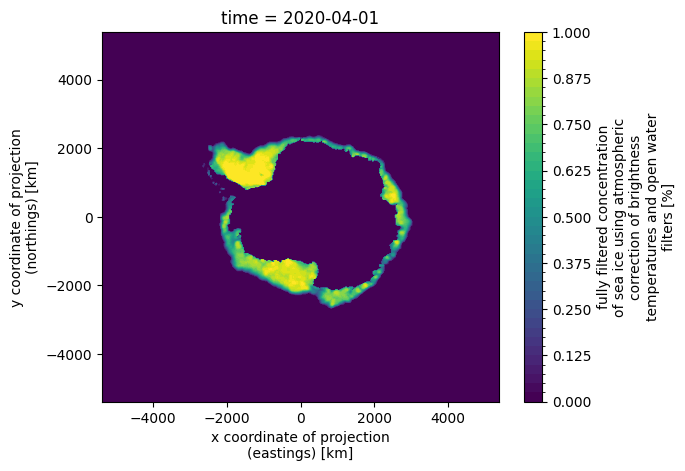

In [30]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=91).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.7_dev